In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
station = session.query(Station).first()
station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28b834fe710>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

In [11]:
measurments = session.query(Measurement).first()
measurments.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28b83509240>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
first_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#session.query(Measurement.date).(func.strftime("%y %m %d", Measurement.date)).all()
first_day 

('2017-08-23')

# Exploratory Climate Analysis

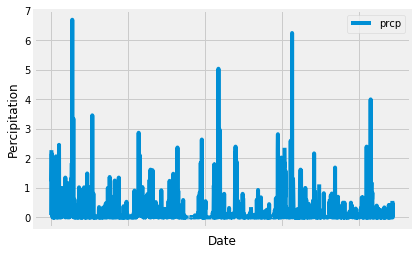

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#last_row = session.query(Measurement.date).order_by(Measurement.date.asc()).limit(1).all()
#rain.order_by(Measurement.date.desc()).limit(1).all()

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date = query_date.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
year_rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > query_date, Measurement.date < "2017-08-23").order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql_query(year_rain.statement, engine, index_col = 'date')

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(use_index = True)
plt.xlabel('Date')
plt.ylabel('Percipitation')    
plt.show()


![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

prcp
count  2011.000000
mean      0.176549
std       0.460667
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

![describe](Images/describe.png)

In [15]:
from sqlalchemy import func
# Design a query to show how many stations are available in this dataset?
ttl_stations = session.query(Measurement.station).group_by(Measurement.station).count()
ttl_stations

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_stations[0][0]
most_active

session.query( func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).filter(Measurement.date > query_date).all()


[(59.0, 83.0, 73.0968660968661)]

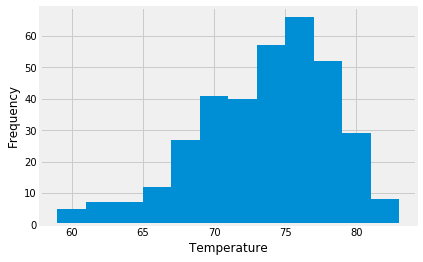

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).filter(Measurement.date > query_date)
tobs_df = pd.read_sql_query(year_temp.statement, engine, index_col = 'date')

plt.hist(tobs_df["tobs"], bins=12)
plt.ylabel('Frequency')    
plt.xlabel('Temperature')    

plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
end_date = '2012-03-05'
start_date = '2012-02-28'
calc_temps(start_date, end_date)


[(62.0, 69.57142857142857, 74.0)]

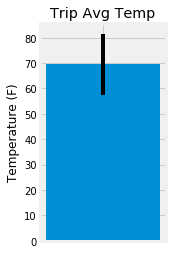

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = (calc_temps(start_date, end_date))[0][0]
tavg = (calc_temps(start_date, end_date))[0][1]
tmax = (calc_temps(start_date, end_date))[0][2]
plt.figure(figsize=(2,4))
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.bar(1,tavg, yerr= tmax - tmin, tick_label="")
plt.show()


In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#, 
weather_stations = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).filter(Measurement.station == Station.station).filter(Measurement.date >= query_date, Measurement.date <= "2017-08-05").group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
station_df = pd.read_sql_query(weather_stations.statement, engine, index_col = 'station')
station_df


#print(weather_stations.all())

name  latitude  longitude  \
station                                                                    
USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   
USC00517948                       PEARL CITY, HI US  21.39340 -157.97510   

             elevation   sum_1  
station                         
USC00516128      152.4  144.27  
USC00519281       32.9   69.52  
USC00513117       14.6   48.51  
USC00519523       19.5   37.67  
USC00514830        7.0   33.10  
USC00519397        3.0   16.07  
USC00517948       11.9    4.59

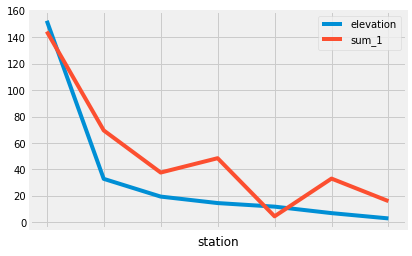

In [23]:
elevation_stations = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).filter(Measurement.station == Station.station).filter(Measurement.date >= query_date, Measurement.date <= "2017-08-05").group_by(Measurement.station).order_by(Station.elevation.desc())
elevation_df = pd.read_sql_query(elevation_stations.statement, engine, index_col = 'station')
el_df = elevation_df[["elevation", "sum_1"]]
el_df.plot()
plt.show()
#Hey look it rains in the mountains 

## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("08-24")

[(70.0, 75.96153846153847, 84.0)]

In [37]:
# calculate the daily normals for your trip
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#start = query_date.strftime("%m-%d-%Y")
normal_datetime = session.query(func.strftime("%m-%d", Measurement.date)).filter(Measurement.date > query_date, Measurement.date < "2017-08-23").group_by(Measurement.date)
#normal_datetime = session.query(Measurement.date).filter(Measurement.date > query_date, Measurement.date < "2017-08-23")

date_df = pd.read_sql_query(normal_datetime.statement, engine)    
date_list =  date_df["strftime_1"].tolist()
#days = date_df.strftime("%m-%d")

normal_values = []
for daily in date_list:
          normal_values.append(*daily_normals(daily))
#normals = [i[0] for i in normal_values]
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [48]:
normal_df = pd.DataFrame(normal_values, columns = ["Min", "Max", "Avg"])
normal_df

Min        Max   Avg
0    70.0  75.961538  84.0
1    69.0  76.960784  82.0
2    71.0  76.568627  84.0
3    68.0  76.283019  84.0
4    67.0  76.734694  86.0
5    70.0  76.235294  85.0
6    68.0  76.416667  84.0
7    67.0  76.840000  85.0
8    69.0  77.000000  82.0
9    67.0  76.666667  83.0
10   69.0  76.137255  83.0
11   68.0  76.270833  84.0
12   66.0  75.914894  84.0
13   66.0  74.911111  81.0
14   64.0  75.180000  82.0
15   66.0  76.222222  83.0
16   68.0  76.365385  84.0
17   67.0  76.612245  85.0
18   70.0  76.695652  83.0
19   68.0  75.897959  85.0
20   68.0  75.875000  82.0
21   69.0  75.980769  85.0
22   67.0  76.140000  81.0
23   70.0  77.403846  86.0
24   68.0  76.576923  83.0
25   67.0  75.851064  84.0
26   68.0  76.346939  87.0
27   69.0  76.145833  83.0
28   67.0  76.448980  84.0
29   69.0  76.372549  84.0
..    ...        ...   ...
334  69.0  76.555556  81.0
335  67.0  76.890909  84.0
336  71.0  76.442308  86.0
337  68.0  76.581818  83.0
338  69.0  76.464286  82.0
339  69.0  76.470588  83.0
340  69.0  77.351852  84.0
341  72.0  77.035714  83.0
342  67.0  75.540000  83.0
343  68.0  75.603774  84.0
344  70.0  76.611111  85.0
345  69.0  76.711538  84.0
346  69.0  76.148148  82.0
347  67.0  76.250000  83.0
348  71.0  77.156863  83.0
349  68.0  76.557692  83.0
350  69.0  75.980392  81.0
351  65.0  76.420000  83.0
352  67.0  75.981132  82.0
353  67.0  76.527273  83.0
354  71.0  76.982456  84.0
355  71.0  76.777778  82.0
356  69.0  76.471698  83.0
357  69.0  76.080000  83.0
358  69.0  76.125000  83.0
359  70.0  76.923077  84.0
360  69.0  75.946429  85.0
361  68.0  76.452830  82.0
362  67.0  76.400000  83.0
363  69.0  76.471698  84.0

[364 rows x 3 columns]

In [49]:
normal_days = session.query(Measurement.date).filter(Measurement.date > query_date, Measurement.date < "2017-08-23").group_by(Measurement.date)

dates_df = pd.read_sql_query(normal_days.statement, engine)    
dates_df

date
0    2016-08-24
1    2016-08-25
2    2016-08-26
3    2016-08-27
4    2016-08-28
5    2016-08-29
6    2016-08-30
7    2016-08-31
8    2016-09-01
9    2016-09-02
10   2016-09-03
11   2016-09-04
12   2016-09-05
13   2016-09-06
14   2016-09-07
15   2016-09-08
16   2016-09-09
17   2016-09-10
18   2016-09-11
19   2016-09-12
20   2016-09-13
21   2016-09-14
22   2016-09-15
23   2016-09-16
24   2016-09-17
25   2016-09-18
26   2016-09-19
27   2016-09-20
28   2016-09-21
29   2016-09-22
..          ...
334  2017-07-24
335  2017-07-25
336  2017-07-26
337  2017-07-27
338  2017-07-28
339  2017-07-29
340  2017-07-30
341  2017-07-31
342  2017-08-01
343  2017-08-02
344  2017-08-03
345  2017-08-04
346  2017-08-05
347  2017-08-06
348  2017-08-07
349  2017-08-08
350  2017-08-09
351  2017-08-10
352  2017-08-11
353  2017-08-12
354  2017-08-13
355  2017-08-14
356  2017-08-15
357  2017-08-16
358  2017-08-17
359  2017-08-18
360  2017-08-19
361  2017-08-20
362  2017-08-21
363  2017-08-22

[364 rows x 1 columns]

In [46]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` inde

trip_df = pd.concat([normal_df, dates_df], axis = 1, sort= True)
trip_df

Min        Max   Avg        date
0    70.0  75.961538  84.0  2016-08-24
1    69.0  76.960784  82.0  2016-08-25
2    71.0  76.568627  84.0  2016-08-26
3    68.0  76.283019  84.0  2016-08-27
4    67.0  76.734694  86.0  2016-08-28
5    70.0  76.235294  85.0  2016-08-29
6    68.0  76.416667  84.0  2016-08-30
7    67.0  76.840000  85.0  2016-08-31
8    69.0  77.000000  82.0  2016-09-01
9    67.0  76.666667  83.0  2016-09-02
10   69.0  76.137255  83.0  2016-09-03
11   68.0  76.270833  84.0  2016-09-04
12   66.0  75.914894  84.0  2016-09-05
13   66.0  74.911111  81.0  2016-09-06
14   64.0  75.180000  82.0  2016-09-07
15   66.0  76.222222  83.0  2016-09-08
16   68.0  76.365385  84.0  2016-09-09
17   67.0  76.612245  85.0  2016-09-10
18   70.0  76.695652  83.0  2016-09-11
19   68.0  75.897959  85.0  2016-09-12
20   68.0  75.875000  82.0  2016-09-13
21   69.0  75.980769  85.0  2016-09-14
22   67.0  76.140000  81.0  2016-09-15
23   70.0  77.403846  86.0  2016-09-16
24   68.0  76.576923  83.0  2016-09-17
25   67.0  75.851064  84.0  2016-09-18
26   68.0  76.346939  87.0  2016-09-19
27   69.0  76.145833  83.0  2016-09-20
28   67.0  76.448980  84.0  2016-09-21
29   69.0  76.372549  84.0  2016-09-22
..    ...        ...   ...         ...
334  69.0  76.555556  81.0  2017-07-24
335  67.0  76.890909  84.0  2017-07-25
336  71.0  76.442308  86.0  2017-07-26
337  68.0  76.581818  83.0  2017-07-27
338  69.0  76.464286  82.0  2017-07-28
339  69.0  76.470588  83.0  2017-07-29
340  69.0  77.351852  84.0  2017-07-30
341  72.0  77.035714  83.0  2017-07-31
342  67.0  75.540000  83.0  2017-08-01
343  68.0  75.603774  84.0  2017-08-02
344  70.0  76.611111  85.0  2017-08-03
345  69.0  76.711538  84.0  2017-08-04
346  69.0  76.148148  82.0  2017-08-05
347  67.0  76.250000  83.0  2017-08-06
348  71.0  77.156863  83.0  2017-08-07
349  68.0  76.557692  83.0  2017-08-08
350  69.0  75.980392  81.0  2017-08-09
351  65.0  76.420000  83.0  2017-08-10
352  67.0  75.981132  82.0  2017-08-11
353  67.0  76.527273  83.0  2017-08-12
354  71.0  76.982456  84.0  2017-08-13
355  71.0  76.777778  82.0  2017-08-14
356  69.0  76.471698  83.0  2017-08-15
357  69.0  76.080000  83.0  2017-08-16
358  69.0  76.125000  83.0  2017-08-17
359  70.0  76.923077  84.0  2017-08-18
360  69.0  75.946429  85.0  2017-08-19
361  68.0  76.452830  82.0  2017-08-20
362  67.0  76.400000  83.0  2017-08-21
363  69.0  76.471698  84.0  2017-08-22

[364 rows x 4 columns]

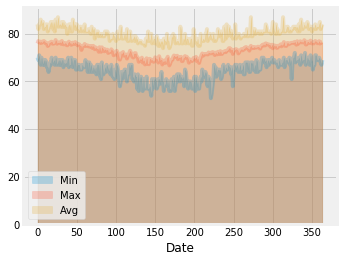

In [45]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, alpha = 0.25, yticks = (np.arange(0, 100, step=20)),figsize = (5,4))
plt.xlabel('Date')
plt.show()